# SHAP for Classification Model
- Reference:
    - [SHAP for Binary and Multiclass Target Variables](https://medium.com/towards-data-science/shap-for-binary-and-multiclass-target-variables-ff2f43de0cf4)
- For classification, SHAP value is interpreted as
    - **Log odds of the positive class** for the *binary targets*: $ln({\frac{P}{1-P}}) = E[ln({\frac{P}{1-P}})] + \text{SHAP values}$
    - **Soft max** for the multi-class targets: need to softmax the $f(x)$ values for each class to get the original prediction probabiliy.


- Goal: to predict the abalone's age (or the number of rings in the abalone shell) which is binned into different groups to create binary and multiclass target variables.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

import shap
shap.initjs()

In [3]:
# import dataset
df = pd.read_csv(
    "../../../data/common_datasets/abalone.data",
    names=[
        "sex",
        "length",
        "diameter",
        "height",
        "whole weight",
        "shucked weight",
        "viscera weight",
        "shell weight",
        "rings",
    ],
)

In [8]:
df.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [7]:
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median")
)
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder()
)
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_exclude=np.number)),
    remainder='passthrough',   # 'drop' and 'passthrough'
    n_jobs=-1
)          # n_job = -1 means that we'll be using all processors to run in parallel.


In [27]:
X = df.drop(columns=["rings"])
# create y as a binary target
y_bin = df["rings"].apply(lambda y: 1 if y > 10 else 0)
y_multi = df["rings"].apply(lambda y: 2 if y>12 else 1 if y>8 else 0)

## Binary Targets

In [14]:
X_transformed = preprocessing.fit_transform(X, y_bin)

In [15]:
X_transformed_df = pd.DataFrame(X_transformed, columns=preprocessing.get_feature_names_out())
X_transformed_df.head()

,pipeline-1__length,pipeline-1__diameter,pipeline-1__height,pipeline-1__whole weight,pipeline-1__shucked weight,pipeline-1__viscera weight,pipeline-1__shell weight,pipeline-2__sex_F,pipeline-2__sex_I,pipeline-2__sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.0,0.0,1.0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0.0,0.0,1.0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1.0,0.0,0.0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0.0,0.0,1.0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0.0,1.0,0.0


In [17]:
#Train model 
model_bin = xgb.XGBClassifier(objective="binary:logistic")
model_bin.fit(X_transformed_df, y_bin)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [20]:
#Get shap values
explainer = shap.Explainer(model_bin)
shap_values_bin = explainer(X_transformed_df)

print(shap_values_bin.shape) #output: (4177, 8)

(4177, 10)


is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


- In this example,
    - $E[f(x)] = E[ln({\frac{P}{1-P}})]$ is the average predicted log odds accross all observations
    - $f(x)=f(ln({\frac{P}{1-P}}))$ is the predicted log odds.
        - In the below example, $f(x)=-0.01882$, so the predicted probability of the positive class is 0.4955 as $ln(0.13218/(1-0.13218))=-1.882$
            - This is aligned with the probability of positive class from the `model.predict_proba` function for the 2nd observation

In [46]:
model_bin.predict_proba(X_transformed_df.loc[1,:].values.reshape((1,-1))) # get the prediction for the 2nd observation (index=1)

array([[0.867813  , 0.13218701]], dtype=float32)

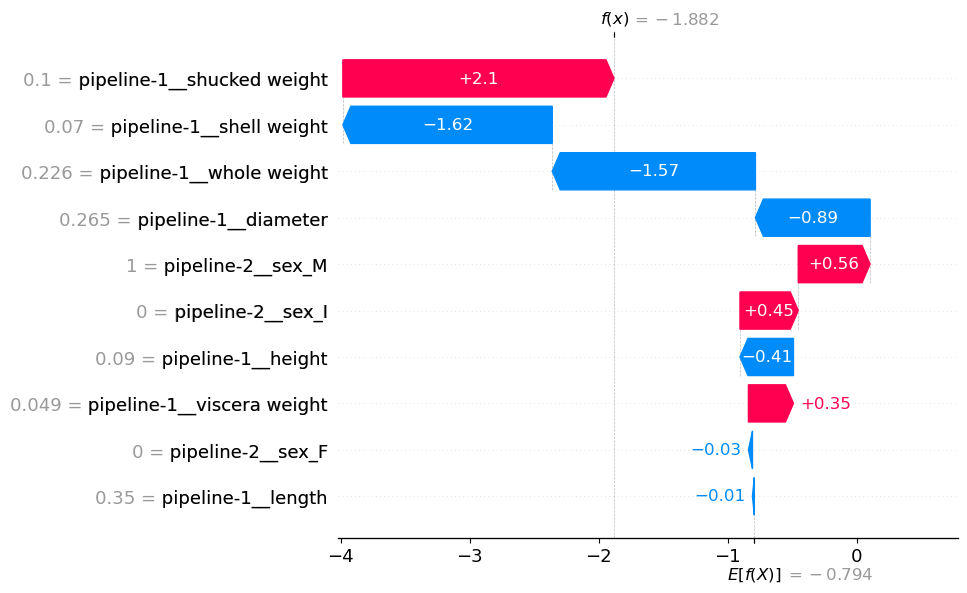

In [41]:
# waterfall plot for 2nd instance (index=1)
shap.plots.waterfall(shap_values_bin[1])

## Multi-Class Target

In [50]:
#Train model 
model_multi = xgb.XGBClassifier(objective="binary:logistic")
model_multi.fit(X_transformed_df, y_multi)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [52]:
model_multi.predict_proba(X_transformed_df.loc[0,:].values.reshape((1,-1)))

array([[0.27506667, 0.15169951, 0.5732338 ]], dtype=float32)

In [54]:
#Get shap values
explainer = shap.Explainer(model_multi)
shap_values_multi= explainer(X_transformed_df)

shap_values_multi.shape

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


(4177, 10, 3)

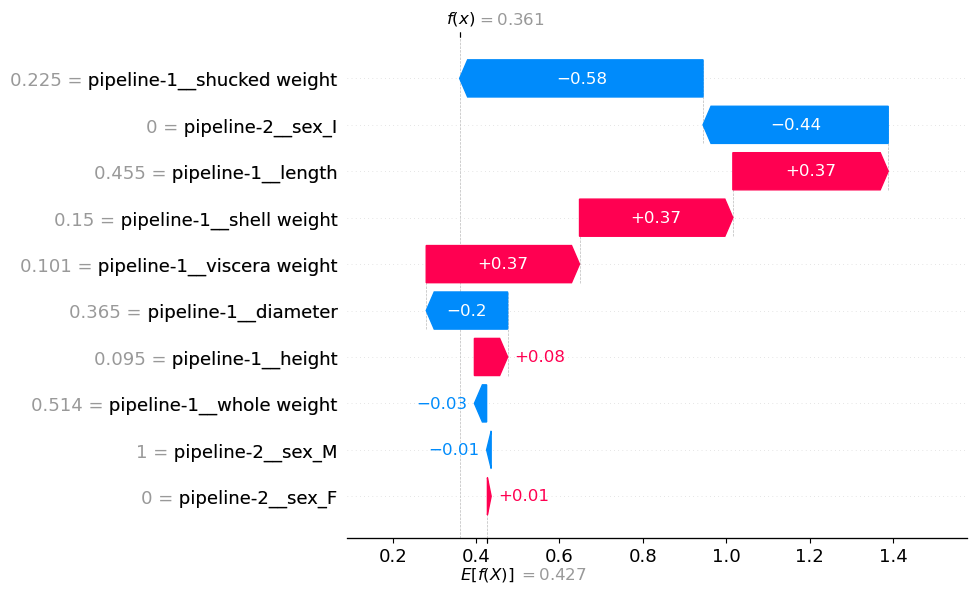

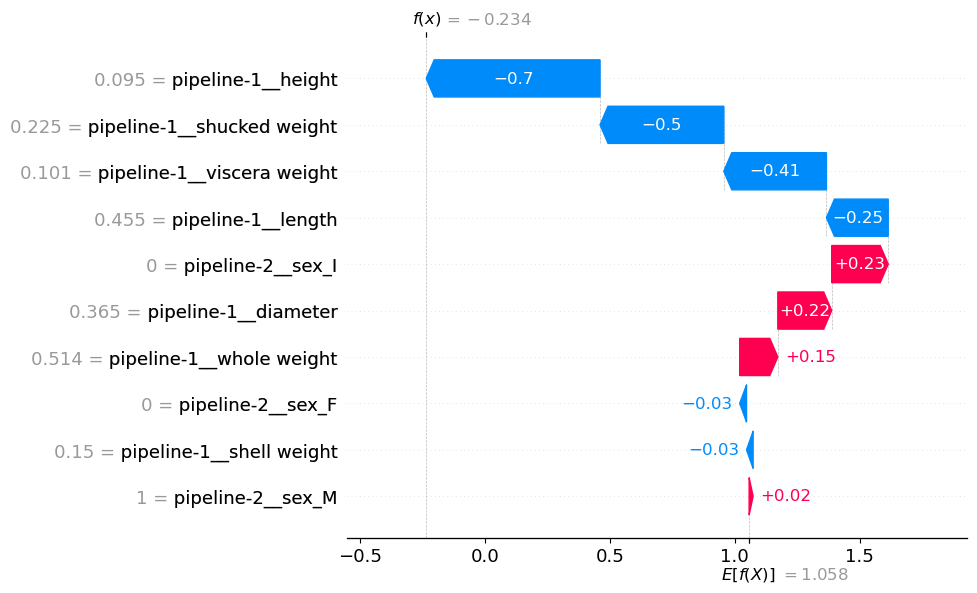

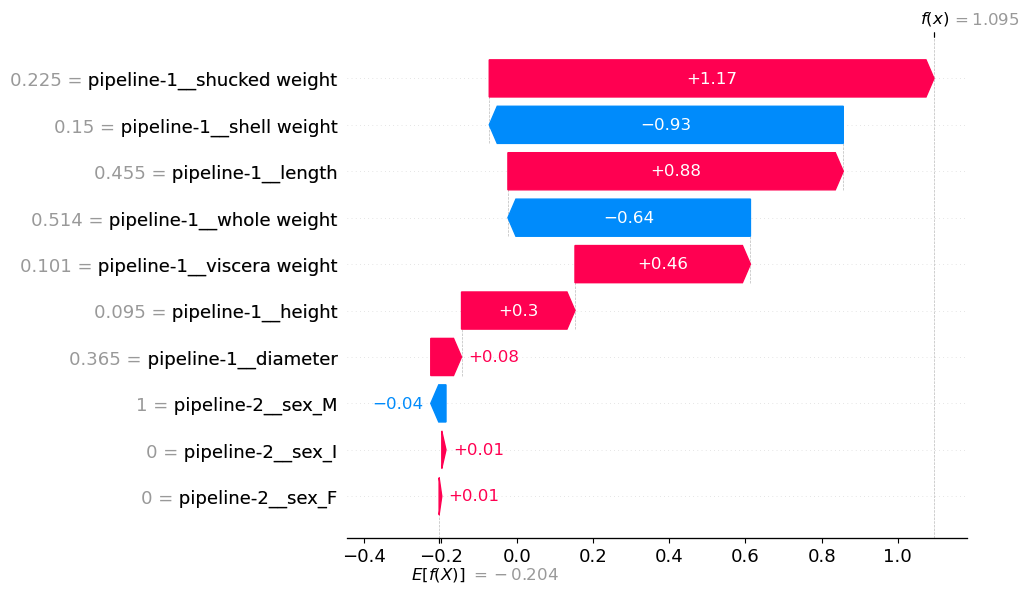

In [56]:
# waterfall plot for class 0 for the first observation
shap.plots.waterfall(shap_values_multi[0, :, 0])
# waterfall plot for class 1 for the first observation
shap.plots.waterfall(shap_values_multi[0, :, 1])
# waterfall plot for class 2 for the first observation
shap.plots.waterfall(shap_values_multi[0, :, 2])

In [57]:
# converting the 3 f(x) softmax values into probability
def softmax(x):
    """Compute softmax values for each sets of scores in x"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


# convert softmax to probability
fx = [0.361,-0.234,1.085]
softmax(fx)

array([0.27668411, 0.1526086 , 0.57070729])

### Mean SHAP

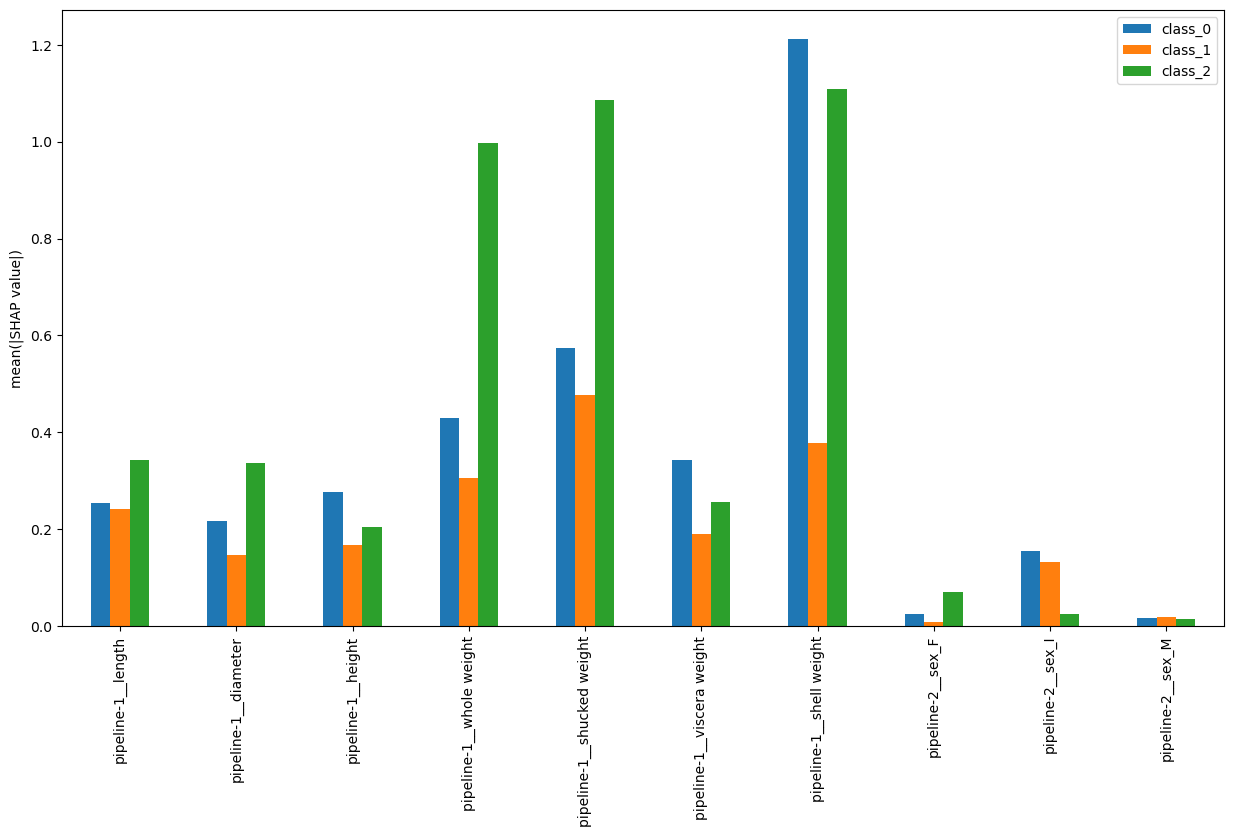

In [66]:
# calculate mean SHAP values for each class
mean_0 = np.mean(np.abs(shap_values_multi.values[:,:,0]),axis=0)
mean_1 = np.mean(np.abs(shap_values_multi.values[:,:,1]),axis=0)
mean_2 = np.mean(np.abs(shap_values_multi.values[:,:,2]),axis=0)

df = pd.DataFrame({'class_0':mean_0,'class_1':mean_1,'class_2':mean_2})

# plot mean SHAP values
fig,ax = plt.subplots(1,1,figsize=(15,8))
df.plot.bar(ax=ax)

ax.set_ylabel('mean(|SHAP value|)')
ax.set_xticklabels(X_transformed_df.columns,rotation=90)
plt.show()


- Each bar gives the average over all the predictions. Yet, the actual predicted class will be different in each case. 

In [68]:
# get model predictions
preds = model_multi.predict(X_transformed_df) # class 0, 1, 2

new_shap_values = []
for i, pred in enumerate(preds):
    # get shap values for predicted class
    new_shap_values.append(shap_values_multi.values[i][:,pred])

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [69]:
shap_values_multi.shape # before: we will have the shap values for 3 class as per observation

(4177, 10, 3)

In [70]:
# replace the SHAP values in the original shap_value object
shap_values_multi.values = np.array(new_shap_values) 
shap_values_multi.shape # after: for each observation, we only keep the SHAP value of the predicted class as the main goal is to explain the predicted value

(4177, 10)

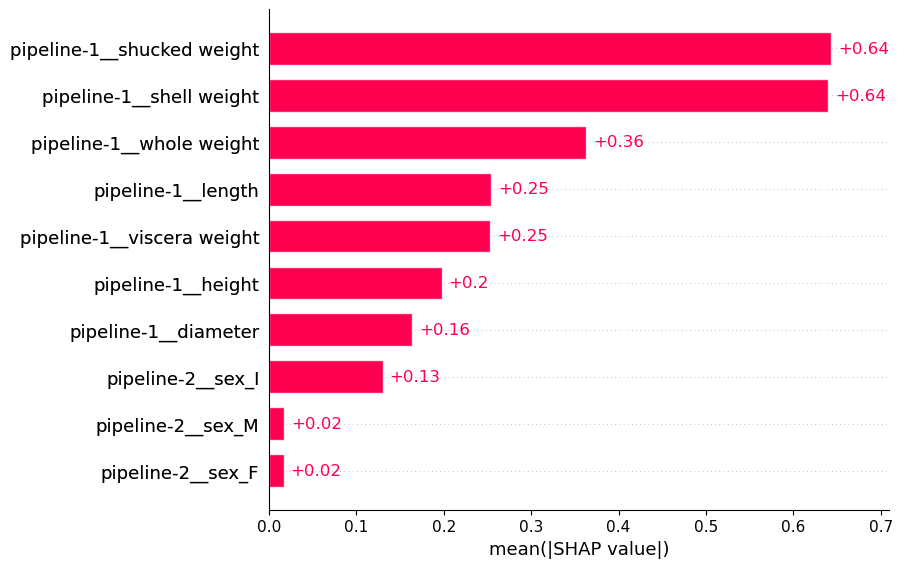

In [71]:
shap.plots.bar(shap_values_multi)